# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs

In [115]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-notebook')

In [124]:
plt.rcParams.update({'xtick.labelsize':13,'ytick.labelsize':13})

In [133]:
#plt.rcParams.keys()
PLOTPATH ='/global/homes/v/vboehm/codes/MADLens/figures' 

In [4]:
from MADLens.util import *

### load TNG power spectra and interpolate 

/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  This is separate from the ipykernel package so we can avoid doing imports until


7.830950132458313


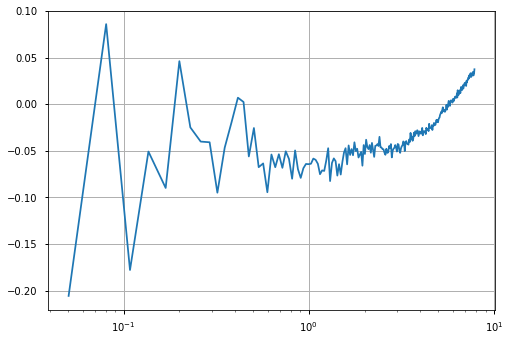

In [3]:
TNG_PATH = '/global/cscratch1/sd/vboehm/TNG_power_spectra/PS_TNG_1'
cat = ArrayCatalog({'Position' : np.asarray([[1.,1.,1.]])}, BoxSize=[205., 205., 205.])
mesh = cat.to_mesh(Nmesh=512, interlaced=True, compensated=True, window='cic')
r = FFTPower(mesh, mode = '1d')
Fpower = r.power['power'].real[1:]
k = r.power['k'][1:]

TNG_pks = []
TNG_zs  = []
for pw in os.listdir(TNG_PATH):
    if 'Dark' in pw:
        redshift = pw[15:19]
        TNG_pks.append(np.loadtxt(os.path.join(TNG_PATH,pw)))
        TNG_zs.append(redshift)
        
TNG_zs  = np.asarray(TNG_zs, dtype=float)
index   = np.argsort(TNG_zs)
TNG_pks = np.asarray(TNG_pks, dtype=float)[index]
TNG_zs  = TNG_zs[index]

TNG_shotnoise = 0.004410944
TNG_Nyquist   = max(k)
print(max(k))

interp = scipy.interpolate.RectBivariateSpline(k, TNG_zs, TNG_pks.T[:len(k), :]-TNG_shotnoise)

def interp_TNG(k,z):
    k = np.asarray(k)
    if k.ndim==0:
        if k<TNG_Nyquist:
            result = interp(k,z)
        else:
            result = interp(TNG_Nyquist,z)*TNG_Nyquist**2*k**(-2)
    else:
        index1 = np.where(k<=TNG_Nyquist)
        index2 = np.where(k>TNG_Nyquist)
        result = np.zeros(k.shape)
        result[index1]= np.squeeze(interp(k[index1],z))
        result[index2]= interp(TNG_Nyquist,z)*TNG_Nyquist**2*k[index2]**(-2)
    
    return np.squeeze(result)

# TNG is systematically low at low k
cosmo = Planck15.clone(P_k_max=50, perturb_sampling_stepsize=0.01,nonlinear=True)
plt.semilogx(k,(interp_TNG(k,0)-cosmo.get_pk(k,0.))/cosmo.get_pk(k,0.))
plt.grid()
plt.show()

### list all possible run files

In [4]:
# run_dir   = '../runs'

# githashes = os.listdir(run_dir)
# for githash in githashes:
#     print(githash)
#     path = os.path.join(run_dir,githash)
#     print(os.listdir(path))

### plot function

In [334]:
def plot(z1_runs, boxsizes, interps, zss, labels, name, noise=None, other = True, other_label=[''], nplots=2, Ns=[100.]):
    
    colors = ['mediumseagreen','coral','royalblue']
    colors2= ['darkgreen', 'firebrick','darkblue']
    if nplots == 2:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    elif nplots ==1:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(8,4))
        ax = [ax]
    else:
        raise ValueError('number of plots not supported')
        
    
    
    for jj, zs in enumerate(np.unique(zss)):
        interp=interps[0]
        boxsize=str(boxsizes[0])
        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']
        if len(np.unique(zss))==1:
            ax[0].loglog(L,x*yt, label='HaloFit', color=colors2[jj])
        else:
            ax[0].loglog(L,x*yt, color=colors2[jj])
            
        if other:
            z    = z1_runs[boxsize][interp][str(zs)].other_cls[str(zs)]['clkk']
            ax[0].loglog(L,x*z, label=other_label, color='gray')
        
    for ii, (boxsize, interp, zs, label) in enumerate(zip(boxsizes,interps,zss, labels)):

        boxsize=str(boxsize)
        print(boxsize, interp, zs, label)

        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        y    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk']
        yerr = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk_std']/z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['N']
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']


        ratio = (y-yt)/yt
        ratio_error = (yerr)/yt 

        
        if len(np.unique(zss))==1:
            ax[0].set_title('$z_{source}$=%.1f'%zs,fontsize=16)
        
        if len(np.unique(zss))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, $z_s=$%.1f'%(label,zs), color=colors[ii])
        elif len(np.unique(boxsizes))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, %s Mpc/h'%(label,boxsize), color=colors[ii])
        else:
            ax[0].loglog(L,x*y, label='MADLens%s'%(label), color=colors[ii])
        
        if noise is not None:
            ax[0].loglog(L,x*noise, label='measured shot noise', color='steelblue')
        
        if ii ==len(zss)-1:
            lss = ['-.','--']
            for ls, N in enumerate(Ns):
                Cl_shape = compute_shape_noise_power(sigma_e=0.4,n=N,fsky=0.1)
                Cl_shape*=(np.pi/(180.*60.))**2
                ax[0].loglog(L,x*Cl_shape, label='shape noise, $n{=}$%d$\mathrm{arcmin}^{-2}$'%N, color='palevioletred', ls=lss[ls])  
        
        ax[0].fill_between(L, x*(y-yerr), x*(y+yerr),color='gray', alpha=0.2)
        
        handles, labels = ax[0].get_legend_handles_labels()
        
        if nplots>1:
            
            ax[1].semilogx(L,ratio, color=colors[ii])
            ax[1].fill_between(L,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
            if len(Ns)==1 and ii ==len(zss)-1:
                ax[1].fill_between(L, -(Cl_shape/yt), (Cl_shape/yt),color='palevioletred', alpha=0.2)
            ax[1].set_ylim(-0.10,0.10)
            ax[1].set_ylabel('relative difference')
            ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)
            ax[1].set_xlabel('$L$',fontsize=16)
        else:
            ax[0].set_xlabel('$L$',fontsize=16)
        
        ax[0].set_ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
        
        if boxsize == '512':
            ax[0].set_xlim(100,10000)
            ax[0].set_ylim(5e-5/2./np.pi,5e-3/2./np.pi)
        else:
            ax[0].set_xlim(200,10000)
            ax[0].set_ylim(6e-5/2./np.pi,2e-3/2./np.pi)
    if np.any(noise==None):
        offset = len(Ns)
    else:
        offset = len(Ns)+1
        
    first_legend = ax[0].legend(handles=handles[-offset::], loc='lower right',fontsize=14,framealpha=0.95)

    # Add the legend manually to the current Axes.
    #ax_ = plt.gca().add_artist(first_legend)
    ax[0].add_artist(first_legend) 
    if len(np.unique(zss))>1:
        sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99)
        ax[0].add_artist(sec_legend) 
    else:
        sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99)
        ax[0].add_artist(sec_legend) 
    if nplots>1:
        ax[1].grid()
    plt.savefig(os.path.join(PLOTPATH,'%s.pdf'%name),bbox_inches='tight')
    plt.show()

In [201]:
boxsizes        = [1024,512,256,128]
interpolations  = ['interp', 'no_interp']
redshifts       = ['0.8', '1.0', '1.2']

runs={}
for boxsize in boxsizes:
    runs[str(boxsize)]={}
    for interp in interpolations:
        runs[str(boxsize)][interp]={}

In [202]:
runs

{'1024': {'interp': {}, 'no_interp': {}},
 '512': {'interp': {}, 'no_interp': {}},
 '256': {'interp': {}, 'no_interp': {}},
 '128': {'interp': {}, 'no_interp': {}}}

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
1 maps were produced in this run
Measuring Cls...
Loading maps...
Computing theory Cls....
loading Pks....


/global/homes/v/vboehm/.local/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1190: ComplexWarning: Casting complex values to real discards the imaginary part
  ye, kx, ky, s)


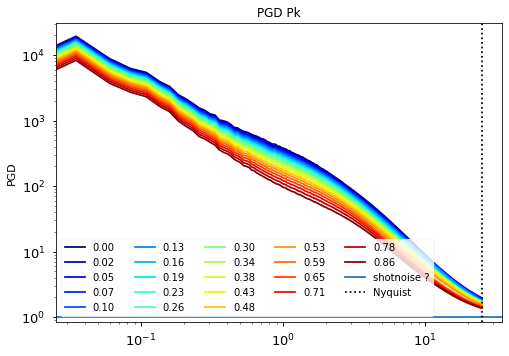

In [224]:
run = Run(githash='3bbfdfb', label='integrated_Pk', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
fN = run.get_Pks()


if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run
    
run.get_other_cls(run.params['zs_source'][0], other=run.interp_PGD, bink=run.measured_cls[str(run.params['zs_source'][0])]['L'])
shotnoise = run.pm.BoxSize.prod()/(run.pm.Nmesh.prod())
# PGD is continuous
plt.title('PGD Pk')
colors = plt.cm.jet(np.linspace(0,1,len(run.pks.keys())))
for ii, zf in enumerate(sorted(run.pks.keys())):
    plt.loglog(run.pks_PGD[zf].power['k'],abs(run.pks_PGD[zf].power['power']), label='%.2f'%float(zf),c=colors[ii])
plt.axhline(shotnoise,label='shotnoise ?')
plt.axvline(fN,ls=':', color='black', label='Nyquist')
plt.legend(ncol=5,loc='lower left')
plt.ylabel('PGD')
plt.show()

In [221]:
run = Run(githash='d4bcb64', label='whitenoise', rnum=0, local_path='../')
run.fill_cl_dicts(downsample=False)
white_noise = run.measured_cls['1.0']['clkk']

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD False and interpolation False.
40 maps were produced in this run
Measuring Cls...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Computing theory Cls....


256 no_interp 1.0 , no interp.


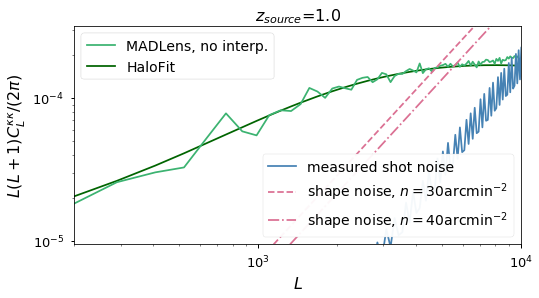

In [332]:
plot(runs, boxsizes=[256], interps=['no_interp'], zss=[1.0], labels=[', no interp.'],other=False, other_label='integrated measured $P_k$', noise=white_noise, nplots=1, name='int_comp', Ns=[30,40])

In [303]:
run = Run(githash='859f754', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 0.80, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Computing theory Cls....


In [304]:
run = Run(githash='5913840', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Computing theory Cls....


In [318]:
run = Run(githash='a349dc9', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.20, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Loading maps...
Computing theory Cls....


512 interp 0.8 
512 interp 1.0 
512 interp 1.2 


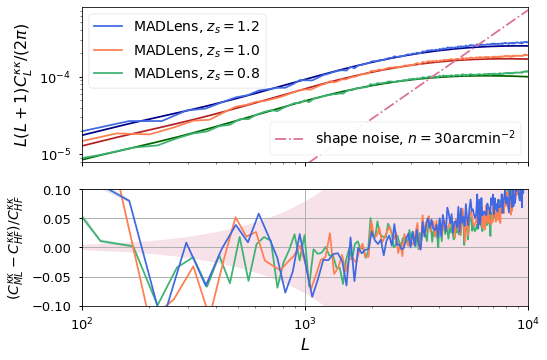

In [335]:
plot(runs, boxsizes=[512, 512, 512], interps=['interp','interp','interp'], zss=[0.8, 1.0, 1.2], other=False,labels=['','',''], name='redshift_comp', Ns=[30])

In [ ]:
run = Run(githash='49b5863', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)


if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

0 highres
1 interp_PGD


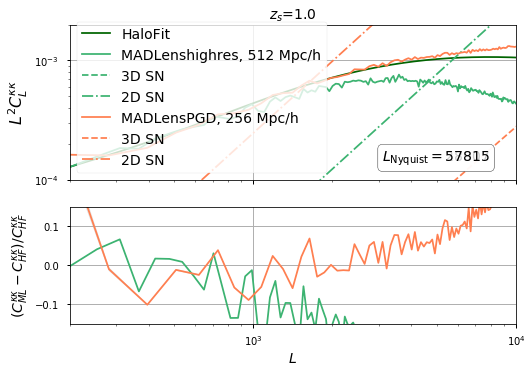

In [94]:
plot(z1_runs, boxsizes=[512,256], interps=['highres','interp_PGD'], zss=[1.0,1.0], labels=[' highres', 'PGD'])

In [184]:
run = Run(githash='539f91c', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['512']['interp']['0.8']=run

Loading run with BoxSize 512, Resolution 512, SourceRedshift 0.80, PGD True and interpolation True.


In [185]:
run = Run(githash='56bbd9b', label='transfer_test', rnum=0, local_path='../', alter_path='/global/cscratch1/sd/vboehm/MADLensOutputs/56bbd9b/')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['256']['interp']['0.8']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 0.80, PGD True and interpolation True.


In [186]:
run = Run(githash='539f91c', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['512']['interp']['0.8']=run

Loading run with BoxSize 512, Resolution 512, SourceRedshift 0.80, PGD True and interpolation True.


In [187]:
run = Run(githash='bc0059d', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['256']['interp']['1.0']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.00, PGD True and interpolation True.


In [93]:
run = Run(githash='f696c01', label='PGD_interp_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['256']['interp_PGD']['1.0']=run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.00, PGD True and interpolation True.


In [189]:
run = Run(githash='e94b9ae', label='transfer_test', rnum=0, local_path='../', alter_path='/global/cscratch1/sd/vboehm/MADLensOutputs/e94b9ae/')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['256']['interp']['1.2'] = run

Loading run with BoxSize 256, Resolution 256, SourceRedshift 1.20, PGD True and interpolation True.


In [193]:
run = Run(githash='dc2637e', label='transfer_test', rnum=0, local_path='../', alter_path='/global/cscratch1/sd/vboehm/MADLensOutputs/dc2637e/')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
z1_runs['256']['interp']['1.0'] = run

Loading run with BoxSize 256, Resolution 1024, SourceRedshift 1.00, PGD False and interpolation False.
less maps produces than requested. Requested:5 Produced:0


UnboundLocalError: local variable 'L' referenced before assignment

0 interp
1 interp_PGD


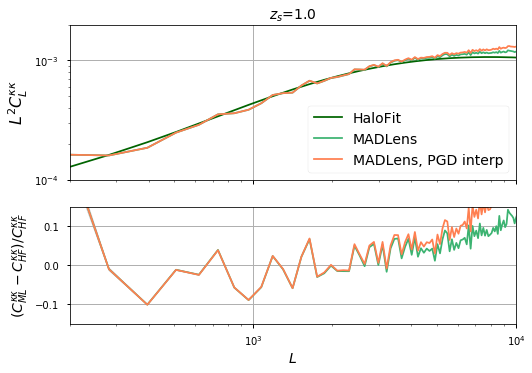

In [190]:
plot(z1_runs, boxsizes=[256,256], interps=['interp','interp_PGD'], zss=[1.0,1.0], labels=['',', PGD interp'])

0 interp
1 interp
2 interp


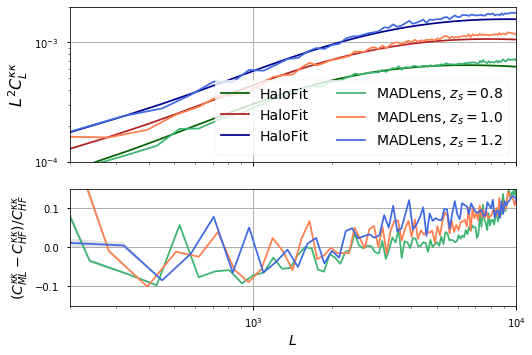

0 interp
1 interp


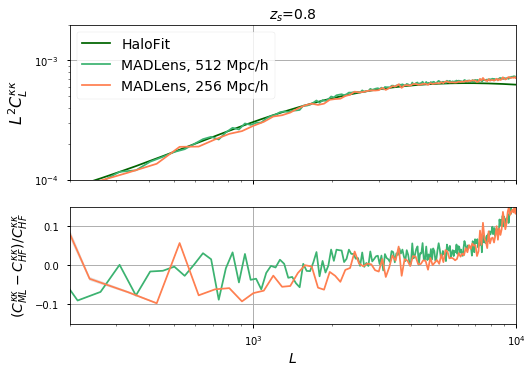

In [192]:
plot(z1_runs, boxsizes=[512,256], interps=['interp','interp'], zss=[0.8,0.8], labels=['',''])

In [ ]:
# load a single map kappa map at a specific source redhsift into memory
mymap = z1_runs['256']['interp']['1.0'].get_map(z_source=z1_runs['256']['interp']['1.0'].params['zs_source'][0],num=0)
down_sampled_map = downsample_map(mymap,512,z1_runs['256']['interp']['1.0'].params)

### plot results

In [ ]:
plt.figure()
plt.title('convergence histogram')
#_ = plt.hist(mymap.value.flatten(),bins=100,density=True, log=True)
_ = plt.hist(down_sampled_map.value.flatten(),bins=100,density=True, log=True)
mean = np.mean(mymap)
plt.axvline(x=mean,color='crimson', label='mean=%.1f'%mean)
plt.legend(fontsize=14)
plt.show()

In [ ]:
down_sampled_map = downsample_map(mymap,512,z1_runs['256']['interp']['1.0'].params)
plt.figure(figsize=(8,8))
plt.title('convergence map')
plt.imshow(np.log(down_sampled_map+1),cmap='viridis')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.colorbar()
plt.show()

<Figure size 360x288 with 0 Axes>

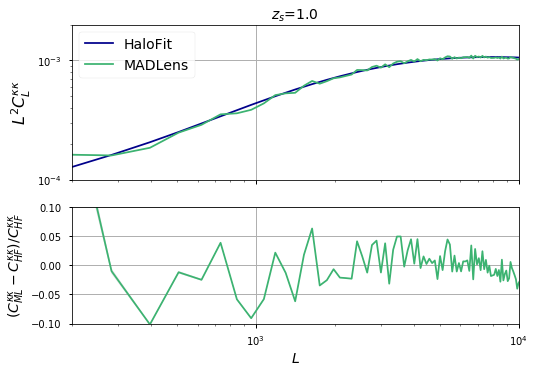

In [19]:

ll   = len(z1_runs['256']['interp']['1.0'].params['zs_source'])

plt.figure(figsize=(ll*5,4))
for ii, zs in enumerate(z1_runs['256']['interp']['1.0'].params['zs_source']):
    
    x    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['L']
    y    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk']
    yerr = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['N']
    yt   = z1_runs['256']['interp']['1.0'].theory_cls[str(zs)]['clkk']
    
    ratio = (y-yt)/yt
    ratio_error = (yerr)/yt 
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
    ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
    ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
    ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
    ax[0].grid()
    
    ax[1].semilogx(x,ratio, color='mediumseagreen')
    ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
    ax[1].grid()
    ax[1].set_ylim(-0.1,0.1)
    ax[1].set_ylabel('relative difference')
    ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
    ax[1].set_xlabel('$L$',fontsize=14)
    ax[0].set_xlim(200,10000)
    ax[0].set_ylim(1e-4,2e-3)

In [20]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['no_interp'][1.0].params['zs_source'])

plt.figure(figsize=(ll*5,4))

    
x    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['L']
y    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['no_interp'][1.0].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,2e-3)

KeyError: 1.0

(0.0001, 0.003)

<Figure size 360x288 with 0 Axes>

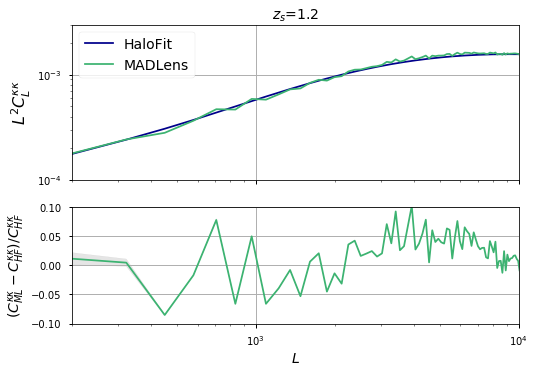

In [40]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['1.2'].params['zs_source'])
zs   = 1.2
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['1.2'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,3e-3)

(8e-05, 0.001)

<Figure size 360x288 with 0 Axes>

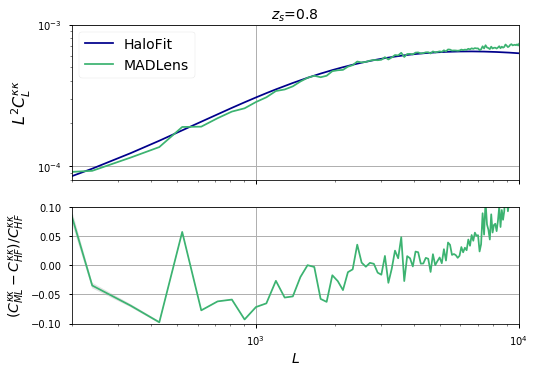

In [22]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.8'].params['zs_source'])
zs   = 0.8
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.8'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

In [2]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.5'].params['zs_source'])
zs   = 0.5
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.5'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

NameError: name 'z1_runs' is not defined

In [127]:
z1_runs['256']['interp'].keys()

dict_keys(['1.0', '0.5'])

In [128]:
z1_runs['256']['interp']['0.5']